In [1]:
# imports
import numpy as np
import pandas as pd
import xgboost as xgb
from collections import OrderedDict
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# helper functions
def StackEnsemble(models, x_train, y_train, x_test, n_folds=5, prob=True, orig_data=True, verbose=True):
    
    def _join(x, preds): 
        x = x if orig_data else np.array([]).reshape(len(x), 0)
        for pred in preds.values():
            x = np.concatenate([x, np.array(pred).reshape(-1, len(set(y_train)) if prob else 1)], axis=1)
        return x
    
    def _predict(x):
        return model.predict_proba(x) if prob else model.predict(x)

    kf = KFold(n_splits = n_folds)
    preds_train = OrderedDict()
    preds_test = OrderedDict()

    for name, model in [(str(type(m)).split('.')[-1][:-2], m) for m in models]:
        if verbose: print('Getting predictions from {}..'.format(name))

        preds_train[name] = []
        for train, test in kf.split(x_train):
            model.fit(x_train[train], y_train[train])
            preds_train[name].extend(_predict(x_train[test]))
        preds_test[name] = _predict(x_test)    

    return _join(x_train, preds_train), _join(x_test, preds_test)

In [3]:
# load processed dataset
df = pd.read_csv('../../data/processed.csv')

# split target from data and create train/test split
x = df.drop('target', axis=1)
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.2, random_state=1337)

# split odds for backtest
odds = x_test[:, 1:25]

In [4]:
# get predictions from 1st level models
models = [LogisticRegression(class_weight='balanced'), 
          KNeighborsClassifier(), 
          RandomForestClassifier(class_weight='balanced')]

x_train_stack, x_test_stack = StackEnsemble(models, x_train, y_train, x_test, prob=True, orig_data=True)

Getting predictions from LogisticRegression..
Getting predictions from KNeighborsClassifier..
Getting predictions from RandomForestClassifier..


In [5]:
# save stacked data for XGB hyperparameter tuning
tune = pd.concat([pd.DataFrame(x_train_stack), pd.Series(y_train)], axis=1)
cols = list(df.columns)[:-1]
cols.extend(['lr_h','lr_d','lr_a','kn_h','kn_d','kn_a','rf_h','rf_d','rf_a','target'])
tune.columns = cols
tune.to_csv('../../data/processed_stack.csv')

/home/daniel/miniconda3/envs/three/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.56      0.86      0.68      1104
          1       0.00      0.00      0.00       604
          2       0.50      0.51      0.50       649

avg / total       0.40      0.54      0.46      2357

0.542638947815


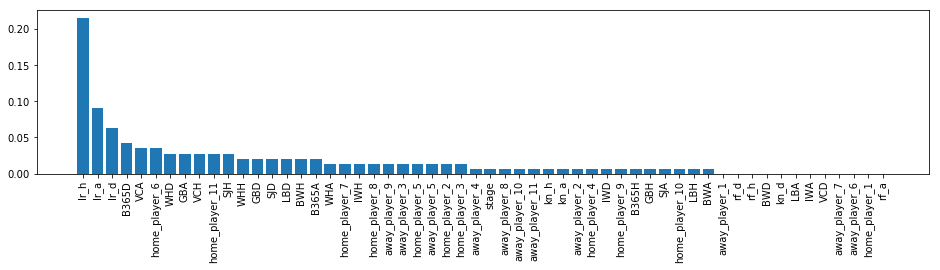

In [6]:
## XGBoost

# train xgboost classifier and get predictions
model = xgb.XGBClassifier(colsample_bytree=0.55,gamma=0,learning_rate=0.1,max_depth=2,n_estimators=16,
                          min_child_weight=4,objective='multi:softmax',reg_alpha=0.05,scale_pos_weight=1,
                          subsample=0.4).fit(x_train_stack, y_train)
preds_xgb = model.predict_proba(x_test_stack)

# evaluate model performance
print(classification_report(y_test, [np.argmax(p) for p in preds_xgb]))
print(accuracy_score(y_test, [np.argmax(p) for p in preds_xgb]))

# get feature importances
tmp = df.drop(['target'], axis=1)
cols = list(x.columns)
cols.extend(['lr_h','lr_d','lr_a','kn_h','kn_d','kn_a','rf_h','rf_d','rf_a'])
feat_importance = pd.DataFrame(pd.concat([pd.Series(model.feature_importances_),
                                          pd.Series(cols)], axis=1)).sort_values(0, ascending=False)

fig, ax = plt.subplots(1,1, figsize=(16, 3))
ax.bar(range(len(feat_importance)), feat_importance.iloc[:,0])
ax.set_xticks(range(x_train_stack.shape[1]))
ax.set_xticklabels(feat_importance.iloc[:,1])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

In [7]:
## Neural Network

# define network architecture
model = Sequential()
model.add(Dense(64, input_dim=x_train_stack.shape[1]))
model.add(PReLU())
model.add(Dropout(0.15))
model.add(Dense(64))
model.add(PReLU())
model.add(Dropout(0.15))
model.add(Dense(3, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
cb = [EarlyStopping(monitor='val_loss', patience=3)]

# train the network
model.fit(x_train_stack, y_train.reshape((-1, 1)), validation_split=0.2, 
          epochs=100, batch_size=128, callbacks=cb, verbose=0)

# get the predictions
preds = model.predict_proba(x_test_stack, verbose=0)

# evaluate model performance
print(classification_report(y_test, [np.argmax(p) for p in preds]))
print(accuracy_score(y_test, [np.argmax(p) for p in preds]))

             precision    recall  f1-score   support

          0       0.54      0.88      0.67      1104
          1       0.00      0.00      0.00       604
          2       0.51      0.44      0.47       649

avg / total       0.39      0.53      0.44      2357

0.533305048791


/home/daniel/miniconda3/envs/three/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
# transform averaged level 2 predictions
predictions = 1 / (preds_xgb + preds / 2)

# concat to backtest data
x_bt = pd.concat([pd.DataFrame(odds), pd.DataFrame(predictions), pd.Series(y_test)], axis=1)
col = cols[1:25] + cols[-9:-6] + ['target']
x_bt.columns = col

x_bt.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,VCH,VCD,VCA,GBH,GBD,GBA,lr_h,lr_d,lr_a,target
0,1.36,4.75,8.50,1.36,4.60,9.0,1.37,4.6,7.5,1.36,...,1.36,5.2,9.5,1.36,4.6,9.00,1.007387,3.254611,4.998085,1
1,1.60,4.20,5.00,1.62,3.60,5.5,1.65,3.4,4.4,1.62,...,1.62,3.8,5.4,1.62,3.6,5.00,1.342904,2.433148,2.903981,1
2,1.17,6.50,19.00,1.16,7.50,12.0,1.17,6.5,11.5,1.17,...,1.17,8.0,21.0,1.15,7.0,15.00,0.867808,5.222123,6.402909,0
3,2.10,3.25,3.75,2.00,3.25,3.8,2.20,3.2,3.0,2.10,...,2.10,3.3,3.8,2.00,3.2,3.75,1.600282,2.201756,2.375706,2
4,1.83,3.60,4.33,1.75,3.75,4.1,1.95,3.4,3.5,1.80,...,1.83,3.8,4.5,1.85,3.3,4.33,1.384490,2.369909,2.810923,0


In [9]:
x_bt.to_csv('../../data/stack_backtest.csv', index=False)